##Part A

Import Required Libraries

In [1]:
# Import necessary libraries
import numpy as np                     # For numerical operations and array handling
import matplotlib.pyplot as plt        # For data visualization (plotting images, graphs)

# Import dataset and utilities from Keras
from keras.datasets import fashion_mnist   # Fashion MNIST dataset (clothing images)
from keras.utils import to_categorical     # Utility to convert labels into one-hot encoding

# Import Keras model and layers
from keras.models import Sequential        # Sequential model (stack layers in order)
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LeakyReLU
# Conv2D → Convolution layer (feature extraction from images)
# MaxPooling2D → Downsampling layer (reduces dimensions)
# Dense → Fully connected layer (classification/decision making)
# Flatten → Converts 2D feature maps into 1D vectors
# LeakyReLU → Activation function (fixes dying ReLU problem)

# Import loss function and optimizer
from keras.losses import categorical_crossentropy  # Loss function for multi-class classification
from keras.optimizers import Adam                  # Adam optimizer (adaptive learning rate)

# Import train-test split utility
from sklearn.model_selection import train_test_split  # Split dataset into train and test sets


Load the Dataset

In [2]:
# Load the Fashion MNIST dataset
# train_X, train_Y → training images and their labels
# test_X, test_Y   → testing images and their labels
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

# Print the shape of training data
# train_X → images, shape will be (60000, 28, 28) → 60k grayscale images of size 28x28
# train_Y → labels, shape will be (60000,) → one label per image
print('Training data shape : ', train_X.shape, train_Y.shape)

# Print the shape of testing data
# test_X → images, shape will be (10000, 28, 28) → 10k grayscale images
# test_Y → labels, shape will be (10000,) → one label per image
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


Visualize a Sample

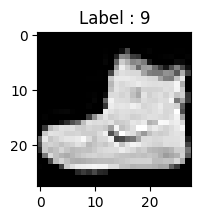

In [3]:
# Plot the first training image with its label
plt.figure(figsize=(2,2))                     # Set figure size to 2x2 inches
plt.imshow(train_X[0,:,:], cmap='gray')       # Display the first image (28x28 pixels) in grayscale
plt.title("Label : {}".format(train_Y[0]))    # Add the label as the title of the image
plt.show()                                    # Show the plotted image

Reshape to include channel dimension

In [4]:
# Reshape the training and testing images to add a channel dimension
# Original shape: (60000, 28, 28) → 3D (samples, height, width)
# New shape:      (60000, 28, 28, 1) → 4D (samples, height, width, channels)
# The last dimension (1) represents grayscale channel (since images are not RGB)

train_X = train_X.reshape(len(train_X), 28, 28, 1)   # Reshape training set
test_X = test_X.reshape(len(test_X), 28, 28, 1)      # Reshape testing set

Normalize

In [5]:
# Normalize pixel values to the range [0, 1]
# Images originally have pixel values in range [0, 255]
# Dividing by 255.0 converts them into floats between 0 and 1
# This helps the neural network train faster and more efficiently

train_X = train_X.astype('float32') / 255    # Normalize training set
test_X = test_X.astype('float32') / 255      # Normalize testing set

One-hot encode labels

In [6]:
# Convert class labels (0–9) into one-hot encoded vectors
# Example:
#   Label 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
#   Label 7 → [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
# This is required because we are using categorical_crossentropy as the loss function,
# which expects one-hot encoded targets for multi-class classification.

train_Y_one_hot = to_categorical(train_Y)   # Shape: (60000, 10)
test_Y_one_hot = to_categorical(test_Y)     # Shape: (10000, 10)

Split into train/validation

In [7]:
# Split the training data into training and validation sets
# train_test_split allows us to hold out a portion of training data for validation
# Validation set is used to monitor the model's performance during training
# test_size=0.2 → 20% of training data becomes validation set
# random_state=0 → ensures reproducibility (same split every time)

train_X, valid_X, train_label, valid_label = train_test_split(
    train_X,               # Input images for training
    train_Y_one_hot,       # One-hot encoded labels for training
    test_size=0.2,         # 20% data for validation
    random_state=0         # Seed for reproducibility
)

##Part B

Hyperparameters

In [8]:
batch_size = 64     # Number of samples per gradient update
# Using batches allows the model to train faster and with less memory usage

epochs = 20         # Number of times the model will iterate over the entire training dataset
# More epochs allow the model to learn better, but too many can cause overfitting

num_classes = 10    # Total number of output classes in the dataset
# Fashion MNIST has 10 categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

CNN Architecture

In [9]:
# Initialize a Sequential model (stack layers one after another)
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(
    32,                     # Number of filters (feature maps) → 32
    kernel_size=(3, 3),     # 3x3 convolution kernel
    activation='linear',    # Linear activation (we'll use LeakyReLU separately)
    input_shape=(28,28,1),  # Input shape: 28x28 grayscale images
    padding='same'          # Padding ensures output has same size as input
))
model.add(LeakyReLU(alpha=0.1))   # LeakyReLU activation with small slope for negative values

# 1st Max Pooling Layer
model.add(MaxPooling2D(
    (2, 2),                # Downsamples the feature map by 2x2
    padding='same'          # Keep dimensions divisible by 2
))

# 2nd Convolutional Layer
model.add(Conv2D(
    64,                    # 64 filters → more complex features
    (3, 3),
    activation='linear',
    padding='same'
))
model.add(LeakyReLU(alpha=0.1))  # Activation
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))  # Downsampling

# 3rd Convolutional Layer
model.add(Conv2D(
    128,                   # 128 filters → capturing even more complex patterns
    (3, 3),
    activation='linear',
    padding='same'
))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten layer to convert 2D feature maps into 1D vector
model.add(Flatten())

# Fully Connected (Dense) layer
model.add(Dense(
    128,                   # 128 neurons
    activation='linear'    # Linear activation; LeakyReLU will be applied next
))
model.add(LeakyReLU(alpha=0.1))

# Output layer
model.add(Dense(
    num_classes,           # 10 classes for Fashion MNIST
    activation='softmax'   # Softmax for multi-class probability distribution
))

# Compile the model
model.compile(
    loss=categorical_crossentropy,   # Loss function for multi-class classification
    optimizer=Adam(),                # Adam optimizer (adaptive learning rate)
    metrics=['accuracy']             # Monitor accuracy during training
)

# Print model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

##Part C

CNN Fitting

In [10]:
results = model.fit(train_X, train_label, batch_size=batch_size,
                    epochs=epochs, validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.7540 - loss: 0.6695 - val_accuracy: 0.8795 - val_loss: 0.3344
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 130s 137ms/step - accuracy: 0.8875 - loss: 0.3044 - val_accuracy: 0.8929 - val_loss: 0.2883
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 134ms/step - accuracy: 0.9076 - loss: 0.2512 - val_accuracy: 0.9024 - val_loss: 0.2601
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - accuracy: 0.9219 - loss: 0.2120 - val_accuracy: 0.9158 - val_loss: 0.2317
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 133ms/step - accuracy: 0.9308 - loss: 0.1855 - val_accuracy: 0.9148 - val_loss: 0.2295
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 138s 128ms/step - accuracy: 0.9425 - loss: 0.1570 - val_accuracy: 0.9143 - val_loss: 0.2340
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 145s 132ms/step - accuracy: 0.9479 - loss: 0.1397 - val_accuracy: 0.9181 - val_loss: 0.2303
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - accuracy: 0.9549 -

CNN Evaluation

In [11]:
# Evaluate the trained model on the test set
# test_X → input test images
# test_Y_one_hot → one-hot encoded labels for test images
# Returns: [loss, accuracy]
test_eval = model.evaluate(test_X, test_Y_one_hot)

# Print the test loss
# Loss indicates how well the model predicts on unseen data
print("Test Loss:", test_eval[0])

# Print the test accuracy
# Accuracy indicates the percentage of correctly classified images
print("Test Accuracy:", test_eval[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9176 - loss: 0.4401
Test Loss: 0.4406392574310303
Test Accuracy: 0.9194999933242798
